# Classification supervised learning 

**Goal:** Predict if a city would be considered as medical desert. 

For that we will do a multinomial classification with 0 = not medical desert, 1 = potential medical desert and 2 = medical desert. To do so we'll use the threshold of DREES that is 2.5 for the APL (under 2.5, the city is considered as a medical desert) and put boundaries to avoid hard threshold for classification. 

**Plan:**
- [x] Preprocessing data to make a proper classification
- [x] Implement Multinomial Logit Regression
- [x] Evaluate the performance of the model 
- [x] Check feature importance
- [ ] Test other model such as Decision Tree to compare the feature importance
- [ ] Test other models to compare the performance of models
- [ ] Iterate and improve the best model

In [75]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('max_columns',30)

In [79]:
df = pd.read_csv('../data/medical_desert_clean.csv', dtype={'CODGEO':'str','Communes':'str'})
print('Shape:',df.shape)
df.head()

Shape: (34989, 26)


,CODGEO,Communes,APL,P16_POP,median_living_standard,healthcare_education_establishments,density_area,annual_pop_growth,unemployment_rate,secondary_residence_rate,vacant_residence_rate,active_local_business_rate,city_social_amenities_rate,0_14_pop_rate,15_59_pop_rate,60+_pop_rate,mobility_rate,average_birth_rate,CSP1_rate,CSP2_rate,CSP3_rate,CSP4_rate,CSP5_rate,CSP6_rate,CSP7_rate,CSP8_rate
0,01001,L'Abergement-Clémenciat,2.396,767,22679.000000,0,48.087774,-0.335578,7.127430,4.597701,7.471264,48.000000,14.000000,20.990874,55.149935,23.859192,2.216428,1.060116,2.479339,3.305785,12.396694,15.702479,16.528926,20.661157,23.966942,4.958678
1,01002,L'Abergement-de-Varey,2.721,243,24382.083333,0,26.557377,0.757662,6.944444,30.769231,9.467456,57.894737,15.789474,22.633745,55.555556,21.810700,2.057613,1.761006,0.000000,10.256410,7.692308,12.820513,20.512821,5.128205,33.333333,10.256410
2,01004,Ambérieu-en-Bugey,4.335,14081,19721.000000,0,572.398374,0.347315,12.038385,1.684887,9.223702,67.838444,17.950636,19.823130,57.904337,22.272533,1.516341,1.595989,0.024879,2.662394,6.939410,17.209926,16.240671,15.940930,24.740051,16.241738
3,01005,Ambérieux-en-Dombes,4.279,1671,23378.000000,0,104.962312,0.872154,6.348660,1.810755,4.979578,55.319149,10.638298,20.521782,58.339888,21.138330,0.985957,1.235096,0.378011,4.511481,7.896554,17.271010,18.019503,17.254154,23.429304,11.239984
4,01006,Ambléon,0.912,110,21660.000000,0,18.707483,-0.359722,11.111111,16.216216,12.162162,71.428571,28.571429,10.909091,54.545455,34.545455,2.727273,1.621622,0.000000,0.000000,5.555556,27.777778,16.666667,16.666667,27.777778,5.555556


________________________
## Preprocessing 

Transform the dataframe to ensure a proper classification modelling. 

**Preprocessing tasks:**
- [x] Drop correlated and useless columns (Communes,P16_POP,60_pop_rate)
- [x] Create binary column to get the dependant variable 
- [x] Change scale of median_living_standard, density_area features
- [x] Check balance of dataset and correct it if needed

In [80]:
from sklearn.preprocessing import maxabs_scale

In [81]:
# Dropping correlated and useless columns

df.drop(columns=['Communes','P16_POP','60+_pop_rate'], inplace = True)
print("Shape after manipulation:", df.shape)

Shape after manipulation: (34989, 23)


In [82]:
# Creating binary column

df['medical_desert'] = df.APL.apply(lambda x: 0 if x>=3 else 1 if x>=2 else 2)
df.drop('APL',axis=1,inplace=True)
print("Shape after manipulation:",df.shape)

Shape after manipulation: (34989, 23)


In [88]:
# Performing scaling transformation depending on the type of data to put all the data between [0,1]
# healthcare_education_establishments is the only column that wasn't changed

df.median_living_standard = df.median_living_standard/100000 
df.density_area = maxabs_scale(df.density_area) # Using maxabs_scale because it does not break the sparsity
df.iloc[:,4:-1] = df.iloc[:,4:-1]/100

df.head()

,CODGEO,median_living_standard,healthcare_education_establishments,density_area,annual_pop_growth,unemployment_rate,secondary_residence_rate,vacant_residence_rate,active_local_business_rate,city_social_amenities_rate,0_14_pop_rate,15_59_pop_rate,mobility_rate,average_birth_rate,CSP1_rate,CSP2_rate,CSP3_rate,CSP4_rate,CSP5_rate,CSP6_rate,CSP7_rate,CSP8_rate,medical_desert
0,01001,0.226790,0,0.001200,-0.003356,0.071274,0.045977,0.074713,0.480000,0.140000,0.209909,0.551499,0.022164,0.010601,0.024793,0.033058,0.123967,0.157025,0.165289,0.206612,0.239669,0.049587,1
1,01002,0.243821,0,0.000663,0.007577,0.069444,0.307692,0.094675,0.578947,0.157895,0.226337,0.555556,0.020576,0.017610,0.000000,0.102564,0.076923,0.128205,0.205128,0.051282,0.333333,0.102564,1
2,01004,0.197210,0,0.014289,0.003473,0.120384,0.016849,0.092237,0.678384,0.179506,0.198231,0.579043,0.015163,0.015960,0.000249,0.026624,0.069394,0.172099,0.162407,0.159409,0.247401,0.162417,0
3,01005,0.233780,0,0.002620,0.008722,0.063487,0.018108,0.049796,0.553191,0.106383,0.205218,0.583399,0.009860,0.012351,0.003780,0.045115,0.078966,0.172710,0.180195,0.172542,0.234293,0.112400,0
4,01006,0.216600,0,0.000467,-0.003597,0.111111,0.162162,0.121622,0.714286,0.285714,0.109091,0.545455,0.027273,0.016216,0.000000,0.000000,0.055556,0.277778,0.166667,0.166667,0.277778,0.055556,2


In [89]:
# Putting the CODGEO as index to avoid loosing the information and because we won't use it as feature

df = df.set_index('CODGEO')

In [90]:
# Checking the balance of the dataset

df.medical_desert.value_counts()

0    18751
1    10719
2     5519
Name: medical_desert, dtype: int64

We can see the dataset is imbalanced so we should make sure it is balanced to avoid biais in the model. 

As the minority is 5000+ observations we can only use under-sampling method to randomly pick the same number of observations in the other classes because it should be enough for modelling. 

In [91]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [92]:
X = df.drop(columns=['medical_desert'])
y = df.medical_desert

In [93]:
# Undersampling all but the minority 
print('Original dataset shape %s' % Counter(y))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 18751, 1: 10719, 2: 5519})
Resampled dataset shape Counter({0: 5519, 1: 5519, 2: 5519})


### Conclusion on preprocessing 

- The data is all on the same scale (between [0,1]) except for the column healthcare_education_establishments
- All the classes have the same number of observations.
- I will keep going without doing any feature engineering methods because I want to see how the model deals with each of the feature (feature importance is one of the output I want to get from modelling). I may do feature enginering to improve the performance of the model afterwards. 

**Possible improvements:**
- Use feature engineering methods to reduce the number of columns

____________________________
## Modelling 

Use Multinomial classification models to predict if the area is going to be a medical desert. 

- 0 = not medical desert
- 1 = potential medical desert
- 2 = medical desert

**Modelling tasks:**
- [x] Split data to train and test samples
- [x] Implement Multinomial Logit Regression
- [x] Evaluate the performance of the model 
- [x] Check feature importance

In [132]:
#load all necessary libraries
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

In [103]:
# Creating train and test samples

print("Features included: \n",list(X.columns.values),'\n')

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=8)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape,'\n')

print("Balance of samples: \n",y_train.value_counts())

Features included: 
 ['median_living_standard', 'healthcare_education_establishments', 'density_area', 'annual_pop_growth', 'unemployment_rate', 'secondary_residence_rate', 'vacant_residence_rate', 'active_local_business_rate', 'city_social_amenities_rate', '0_14_pop_rate', '15_59_pop_rate', 'mobility_rate', 'average_birth_rate', 'CSP1_rate', 'CSP2_rate', 'CSP3_rate', 'CSP4_rate', 'CSP5_rate', 'CSP6_rate', 'CSP7_rate', 'CSP8_rate'] 

(11589, 21)
(4968, 21)
(11589,)
(4968,) 

Balance of samples: 
 2    3881
1    3862
0    3846
Name: medical_desert, dtype: int64


In [203]:
def logit_model(X_train,y_train):
    logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
    logit_model = logit_model.fit()
    #display results
    display(logit_model.summary2())
    display(logit_model.pred_table())
    
logit_model(X_train,y_train)

Optimization terminated successfully.
         Current function value: 1.007430
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: MNLogit
=========================================================================================
Model:                      MNLogit                  Pseudo R-squared:         0.083     
Dependent Variable:         medical_desert           AIC:                      23438.2156
Date:                       2020-05-21 19:40         BIC:                      23761.9593
No. Observations:           11589                    Log-Likelihood:           -11675.   
Df Model:                   42                       LL-Null:                  -12732.   
Df Residuals:               11545                    LLR p-value:              0.0000    
Converged:                  1.0000                   Scale:                    1.0000    
No. Iterations:             9.0000                                                       
-----------------------------------------------------------------------------------------
           medical_desert = 0             Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------------------------------
                              const      -0.5309   1.5190 -0.3495 0.7267  -3.5081  2.4462
             median_living_standard       6.2835   1.1208  5.6060 0.0000   4.0867  8.4803
healthcare_education_establishments      -0.3214   0.1505 -2.1353 0.0327  -0.6165 -0.0264
                       density_area      -0.5984   1.4274 -0.4193 0.6750  -3.3960  2.1991
                  annual_pop_growth      -3.0637   1.5685 -1.9533 0.0508  -6.1379  0.0105
                  unemployment_rate       0.6596   0.7516  0.8776 0.3801  -0.8135  2.1327
           secondary_residence_rate       1.7063   0.2282  7.4769 0.0000   1.2590  2.1535
              vacant_residence_rate       2.5734   0.5850  4.3992 0.0000   1.4269  3.7199
         active_local_business_rate      -1.5820   0.1834 -8.6265 0.0000  -1.9415 -1.2226
         city_social_amenities_rate      -1.6776   0.3391 -4.9472 0.0000  -2.3422 -1.0130
                      0_14_pop_rate       4.1817   0.7781  5.3743 0.0000   2.6567  5.7067
                     15_59_pop_rate      -0.6419   0.5941 -1.0805 0.2799  -1.8062  0.5225
                      mobility_rate       3.3470   3.9961  0.8375 0.4023  -4.4853 11.1792
                 average_birth_rate       2.5867   7.8517  0.3294 0.7418 -12.8024 17.9758
                          CSP1_rate       1.4229   1.5841  0.8982 0.3691  -1.6820  4.5277
                          CSP2_rate      -1.1742   1.6037 -0.7322 0.4641  -4.3174  1.9690
                          CSP3_rate      -0.9321   1.5699 -0.5937 0.5527  -4.0091  2.1448
                          CSP4_rate      -0.6425   1.5216 -0.4222 0.6729  -3.6248  2.3399
                          CSP5_rate      -1.1115   1.5154 -0.7335 0.4633  -4.0817  1.8586
                          CSP6_rate       0.2862   1.5095  0.1896 0.8496  -2.6724  3.2447
                          CSP7_rate      -0.9530   1.4733 -0.6469 0.5177  -3.8405  1.9346
                          CSP8_rate      -1.5091   1.5094 -0.9998 0.3174  -4.4676  1.4493
-----------------------------------------------------------------------------------------
         medical_desert = 1           Coef.   Std.Err.    t     P>|t|    [0.025   0.975] 
-----------------------------------------------------------------------------------------
                              const   -3.9333   1.4381  -2.7350 0.0062   -6.7520  -1.1146
             median_living_standard    9.8173   1.1722   8.3754 0.0000    7.5199  12.1147
healthcare_education_establishments   -0.8391   0.5971  -1.4053 0.1599   -2.0094   0.3312
                       density_area -106.9475  13.4038  -7.9789 0.0000 -133.2185 -80.6765
                  annual_pop_growth   -0.8711   1.5336  -0.5681 0.5700   -3.8769   2.1346
                  unemployment_rate    3.3907   0.7260   4.6701 0.0000    1.9676   4.8137
           secondary_residen

array([[2178.,  905.,  763.],
       [1466., 1280., 1116.],
       [ 769.,  859., 2253.]])

### Conclusion on first iteration of Logistic Regression model
- The performance of the model is really low with a pseudo R-squared of 0.083
- We can see in the prediction table that around half of the data are True Positive so we should run with a low accuracy score as well
- When looking at the t-value of the features we can see many of them are not so relevant for the model (i.e. density_area, unemployement_rate). As Logistic Regression is really sensitive to irrelevant variable, it may explain the low performance of the model. 

**Possible improvements:**
- Performing feature selection methods using ANOVA (F-classification) and Sequencial Feature Selection
- Try Decision Tree model that automatically perform feature selection and check the importance of 

_______________________________
## Feature Selection

Find out the more relevant features among the 21 available. 

**Tasks:**
- [x] Perform feature selection using ANOVA F measure
- [x] Check feature importance
- [x] Perform SFS feature selection 
- [x] Compare the feature importance of both methods 
- [x] Run Logistic Regression model using the best features
- [x] Compare model performance to the previous 

In [179]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [225]:
def feat_selection_anova(X, y, test_sample=[], k='all'):
    fs = SelectKBest(score_func=f_classif, k=k)
    fs = fs.fit(X, y)
    X_fs = fs.transform(X)
    # X_test can be passed in case of performing the function for X_train and X_test samples
    if len(test_sample)!=0:
        X_test_fs = fs.transform(test_sample)
        return X_fs, X_test_fs, fs
    else:
        return X_fs, fs

# feature selection
X_fs, anova = feat_selection_anova(X_res,y_res)

# what are scores for the features
for i in range(len(anova.scores_)):
    print('Feature %d: %f' % (i, anova.scores_[i]))

# plot the scores
ordered_col_idx = [idx for score, idx in sorted(list(zip(anova.scores_, X_res.columns.values)), reverse=True)]
anova_score_ordered = sorted(anova.scores_, reverse=True)

Feature 0: 76.877098
Feature 1: 49.710955
Feature 2: 108.866967
Feature 3: 24.944204
Feature 4: 17.116307
Feature 5: 942.856778
Feature 6: 47.580143
Feature 7: 348.170475
Feature 8: 21.292036
Feature 9: 175.010400
Feature 10: 125.895716
Feature 11: 19.108502
Feature 12: 93.571231
Feature 13: 283.912269
Feature 14: 10.086979
Feature 15: 51.548307
Feature 16: 68.253749
Feature 17: 58.316292
Feature 18: 56.249528
Feature 19: 77.889365
Feature 20: 33.700080


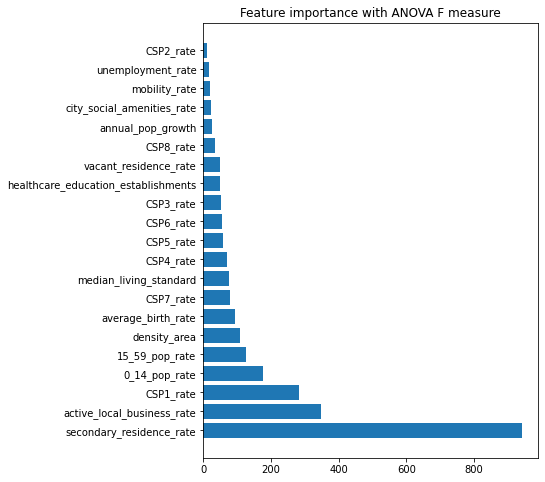

In [201]:
# Plot the results 

plt.figure(figsize=(6,8))
plt.barh([i for i in range(len(anova.scores_))], anova_score_ordered, tick_label=ordered_col_idx)
plt.title('Feature importance with ANOVA F measure')
plt.savefig('../img/anova_feature_selection.png')
plt.show()

In [223]:
# Try feature selection using SFS - WARNING takes time to run

def feat_selection_sfs(X, y, test_sample=[], k=(1,(X.shape[1]))):
    estimator = LogisticRegression(max_iter=1000)
    sfs = SFS(estimator, k_features=k, forward=True, cv=3)
    sfs = sfs.fit(X, y)
    X_fs = sfs.transform(X)
    # X_test can be passed in case of performing the function for X_train and X_test samples
    if len(test_sample)!=0:
        X_test_fs = sfs.transform(test_sample)
        return X_fs, X_test_fs, sfs
    else:
        return X_fs, sfs

In [209]:
X_sfs, sfs = feat_selection_sfs(X_res,y_res)
metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
metrics

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[0.4805218336655191, 0.42960681282841096, 0.42...",0.44374,"(secondary_residence_rate,)",0.059049,0.0262402,0.0185546
2,"(5, 18)","[0.4946548287733285, 0.44392100018119224, 0.44...",0.46053,"(secondary_residence_rate, CSP6_rate)",0.0543061,0.0241325,0.0170643
3,"(5, 9, 18)","[0.5019025185722051, 0.4506251132451531, 0.441...",0.464698,"(secondary_residence_rate, 0_14_pop_rate, CSP6...",0.0597833,0.0265665,0.0187853
4,"(2, 5, 9, 18)","[0.5089690161261098, 0.45098749773509694, 0.44...",0.46814,"(density_area, secondary_residence_rate, 0_14_...",0.0652433,0.0289928,0.020501
5,"(2, 5, 7, 9, 18)","[0.5116868998006885, 0.4596847254937489, 0.434...",0.468503,"(density_area, secondary_residence_rate, activ...",0.0726135,0.0322679,0.0228169
6,"(2, 5, 6, 7, 9, 18)","[0.514767167965211, 0.46421453161804677, 0.434...",0.471281,"(density_area, secondary_residence_rate, vacan...",0.0742651,0.0330019,0.0233358
7,"(2, 5, 6, 7, 9, 13, 18)","[0.5113245153107447, 0.46421453161804677, 0.44...",0.472368,"(density_area, secondary_residence_rate, vacan...",0.0653872,0.0290567,0.0205462
8,"(2, 5, 6, 7, 9, 10, 13, 18)","[0.5178474361297336, 0.46548287733285015, 0.44...",0.475026,"(density_area, secondary_residence_rate, vacan...",0.0715432,0.0317923,0.0224806
9,"(2, 3, 5, 6, 7, 9, 10, 13, 18)","[0.5185722051096213, 0.46457691610799057, 0.44...",0.475932,"(density_area, annual_pop_growth, secondary_re...",0.070278,0.0312301,0.022083
10,"(2, 3, 5, 6, 7, 9, 10, 13, 18, 19)","[0.5173038593948179, 0.4683819532524008, 0.443...",0.476475,"(density_area, annual_pop_growth, secondary_re...",0.0687988,0.0305728,0.0216182


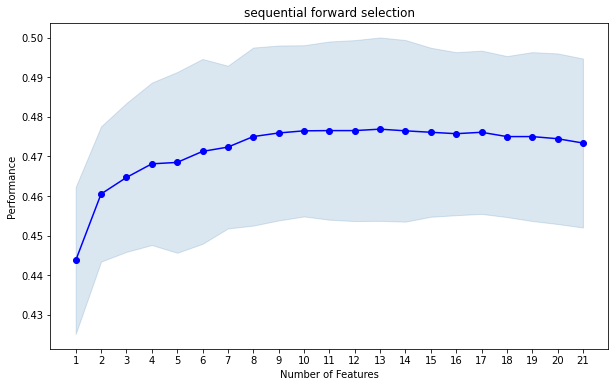

In [208]:
fig=plot_sfs(sfs.get_metric_dict(), kind='std_err',figsize=(10,6))
plt.title("sequential forward selection")
plt.savefig('../img/sfs_feature_selection.png')
plt.show()

In [239]:
# Comparing the list of features from both methods

print("List of features with ANOVA: \n",ordered_col_idx[:4])
print("List of features with SFS: \n",metrics.loc[4,'feature_names'])
# 7 seems to be resonable number of features with highest prediction score and small std_err
print("List of features with SFS: \n",metrics.loc[7,'feature_names'])

List of features with ANOVA: 
 ['secondary_residence_rate', 'active_local_business_rate', 'CSP1_rate', '0_14_pop_rate']
List of features with SFS: 
 ('density_area', 'secondary_residence_rate', '0_14_pop_rate', 'CSP6_rate')
List of features with SFS: 
 ('density_area', 'secondary_residence_rate', 'vacant_residence_rate', 'active_local_business_rate', '0_14_pop_rate', 'CSP1_rate', 'CSP6_rate')


In [226]:
# Building again the MNLogit with the best features

# selection the features with the train/test samples
X_train_anova, X_test_anova, anova = feat_selection_anova(X_train, y_train, X_test, k=4)
X_train_sfs_4, X_test_sfs_4, sfs_4 = feat_selection_sfs(X_train, y_train, X_test, k=4)
X_train_sfs_6, X_test_sfs_6, sfs_6 = feat_selection_sfs(X_train, y_train, X_test, k=7)

In [228]:
# running the MNlogit model (statsmodels)
print("ANOVA feature selection")
logit_model(X_train_anova,y_train)

print("========================================================")
print("SFS_4 feature selection")
logit_model(X_train_sfs_4, y_train)

print("========================================================")
print("SFS_7 feature selection")
logit_model(X_train_sfs_6, y_train)

ANOVA feature selection
Optimization terminated successfully.
         Current function value: 1.024746
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
===================================================================
Model:                MNLogit          Pseudo R-squared: 0.067     
Dependent Variable:   medical_desert   AIC:              23771.5679
Date:                 2020-05-21 20:12 BIC:              23845.1460
No. Observations:     11589            Log-Likelihood:   -11876.   
Df Model:             8                LL-Null:          -12732.   
Df Residuals:         11579            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       6.0000                                       
------------------------------------------------------------------
medical_desert = 0  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const  -0.2640   0.1448 -1.8232 0.0683 -0.5477  0.0198
               x1   1.3369   0.2062  6.4848 0.0000  0.9329  1.7410
               x2  -1.5244   0.1644 -9.2719 0.0000 -1.8467 -1.2022
               x3   4.0446   0.5707  7.0869 0.0000  2.9260  5.1632
               x4   2.8270   0.5767  4.9020 0.0000  1.6967  3.9573
-------------------------------------------------------------------
medical_desert = 1  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
             const -0.5644   0.1452  -3.8880 0.0001 -0.8489 -0.2799
                x1  4.9066   0.1941  25.2734 0.0000  4.5261  5.2871
                x2 -2.4151   0.1693 -14.2681 0.0000 -2.7469 -2.0833
                x3  4.0156   0.5841   6.8743 0.0000  2.8707  5.1605
                x4  4.6730   0.5549   8.4220 0.0000  3.5855  5.7605
===================================================================

"""

array([[2206.,  872.,  768.],
       [1589., 1199., 1074.],
       [ 972.,  865., 2044.]])

SFS_4 feature selection
Optimization terminated successfully.
         Current function value: 1.027318
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
===================================================================
Model:                MNLogit          Pseudo R-squared: 0.065     
Dependent Variable:   medical_desert   AIC:              23831.1652
Date:                 2020-05-21 20:12 BIC:              23904.7433
No. Observations:     11589            Log-Likelihood:   -11906.   
Df Model:             8                LL-Null:          -12732.   
Df Residuals:         11579            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       5.0000                                       
-------------------------------------------------------------------
medical_desert = 0  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
             const  0.0385   0.2615   0.1471 0.8831 -0.4741  0.5510
                x1  1.4613   0.2166   6.7453 0.0000  1.0367  1.8859
                x2 -1.8304   0.1533 -11.9435 0.0000 -2.1308 -1.5301
                x3  3.9329   0.5833   6.7420 0.0000  2.7896  5.0762
                x4 -0.1317   0.4605  -0.2860 0.7749 -1.0343  0.7709
-------------------------------------------------------------------
medical_desert = 1  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
             const -0.9439   0.2628  -3.5914 0.0003 -1.4590 -0.4288
                x1  5.3421   0.2049  26.0720 0.0000  4.9405  5.7436
                x2 -3.0657   0.1585 -19.3428 0.0000 -3.3763 -2.7551
                x3  3.3469   0.5959   5.6165 0.0000  2.1790  4.5149
                x4  1.6701   0.4617   3.6176 0.0003  0.7653  2.5750
===================================================================

"""

array([[2171.,  907.,  768.],
       [1538., 1276., 1048.],
       [ 950.,  899., 2032.]])

SFS_6 feature selection
Optimization terminated successfully.
         Current function value: 1.022317
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
===================================================================
Model:                MNLogit          Pseudo R-squared: 0.069     
Dependent Variable:   medical_desert   AIC:              23727.2549
Date:                 2020-05-21 20:12 BIC:              23844.9799
No. Observations:     11589            Log-Likelihood:   -11848.   
Df Model:             14               LL-Null:          -12732.   
Df Residuals:         11573            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       5.0000                                       
-------------------------------------------------------------------
medical_desert = 0  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
             const -0.3849   0.2944  -1.3075 0.1910 -0.9619  0.1921
                x1 -2.1293   0.6707  -3.1746 0.0015 -3.4439 -0.8147
                x2  1.6956   0.2196   7.7199 0.0000  1.2651  2.1260
                x3  2.4906   0.5581   4.4628 0.0000  1.3968  3.5844
                x4 -1.5956   0.1586 -10.0612 0.0000 -1.9064 -1.2847
                x5  4.2020   0.6007   6.9955 0.0000  3.0247  5.3792
                x6 -0.0100   0.4776  -0.0209 0.9833 -0.9461  0.9261
                x7  0.9028   0.3391   2.6622 0.0078  0.2382  1.5675
-------------------------------------------------------------------
medical_desert = 1  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
             const -2.1417   0.2966  -7.2212 0.0000 -2.7230 -1.5604
                x1 -0.3187   0.6594  -0.4834 0.6288 -1.6111  0.9737
                x2  5.7312   0.2107  27.2063 0.0000  5.3183  6.1441
                x3  5.2334   0.5578   9.3816 0.0000  4.1400  6.3267
                x4 -2.8200   0.1626 -17.3403 0.0000 -3.1388 -2.5013
                x5  4.4274   0.6131   7.2218 0.0000  3.2258  5.6290
                x6  2.5481   0.4784   5.3264 0.0000  1.6105  3.4858
                x7 -0.4333   0.3502  -1.2373 0.2160 -1.1196  0.2530
===================================================================

"""

array([[2156.,  883.,  807.],
       [1498., 1289., 1075.],
       [ 854.,  882., 2145.]])

In [237]:
# building LogisticRegression (sklearn)

def logistic_reg(X_train, y_train, X_test, y_test, method=''):
    model = LogisticRegression(multi_class='multinomial',random_state=8)
    model = model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    print("==================================================")
    print(f"{method} feature selection")
    print("Accuracy score for train sample:", accuracy_score(y_train, y_train_pred))
    print("Accuracy score for test sample:", accuracy_score(y_test, y_pred))
    print("Classification report: \n",classification_report(y_test, y_pred))

In [238]:
logistic_reg(X_train_anova, y_train, X_test_anova, y_test, 'ANOVA')
logistic_reg(X_train_sfs_4, y_train, X_test_sfs_4, y_test, 'SFS_4')
logistic_reg(X_train_sfs_6, y_train, X_test_sfs_6, y_test, 'SFS_7')

ANOVA feature selection
Accuracy score for train sample: 0.4694106480283027
Accuracy score for test sample: 0.4607487922705314
Classification report: 
               precision    recall  f1-score   support

           0       0.46      0.55      0.50      1673
           1       0.40      0.32      0.35      1657
           2       0.51      0.51      0.51      1638

    accuracy                           0.46      4968
   macro avg       0.46      0.46      0.46      4968
weighted avg       0.46      0.46      0.46      4968

SFS_4 feature selection
Accuracy score for train sample: 0.4717404435240314
Accuracy score for test sample: 0.46557971014492755
Classification report: 
               precision    recall  f1-score   support

           0       0.47      0.55      0.50      1673
           1       0.40      0.33      0.36      1657
           2       0.52      0.51      0.52      1638

    accuracy                           0.47      4968
   macro avg       0.46      0.47      0.4

### Conclusion on feature selection 

MNLogit model (statsmodel):
- The performance is still not that good but improved slightly with feature selection. 
- When we keep only 4 features, the ANOVA method has better performance (2 columns are similar) which seems relevant when looking at the features_names
- Altough the model had a slightly better performance when having 7 features (the 4 features of ANOVA are included)

LogisticRegression model (sklearn):
- The three feature selection methods have quite the same performance on the model although having 7 features seems to have better results.

Global conclusion:
- We don't have any overfitting of models
- Logistic Regression doesn't seem to be the best model, we should try other models

**Possible improvements:**
- Build Decision Tree model to compare the feature selection and the model performance
- Use other Multinomial classificatin method to compare the performance

___________________________
## Decision Tree iteration

Build Decision Tree model to check if we can see any improvement in the model performance and compare the feature importance autotycally done by the model. 

In [242]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [243]:
# Using Cross_val_score sklearn function
tree = DecisionTreeClassifier(random_state=42)
csv = cross_val_score(tree, X_res, y_res, cv=10)

print(csv)
print("Average accuracy:",np.mean(csv))

[0.43055556 0.43719807 0.44142512 0.43115942 0.40096618 0.41364734
 0.397343   0.40302115 0.37583082 0.4163142 ]
Average accuracy: 0.4147460849132332


In [244]:
# Using StratifiedKFold for cross-validation
accuracies_train=[]
accuracies_test=[]
skf = StratifiedKFold(n_splits=10, random_state=8, shuffle=True) 
dtree_cv = DecisionTreeClassifier(random_state=42)

for train_idx, test_idx in skf.split(X_res,y_res):
    dtree_cv = dtree_cv.fit(X.iloc[train_idx,:],y[train_idx])
    accuracies_train.append(accuracy_score(y[train_idx],dtree_cv.predict(X.iloc[train_idx,:])))
    accuracies_test.append(accuracy_score(y[test_idx],dtree_cv.predict(X.iloc[test_idx,:])))
    
print("Average accuracy for train samples:",np.mean(accuracies_train))
print("Average accuracy for test samples:",np.mean(accuracies_test))

Average accuracy for train samples: 1.0
Average accuracy for test samples: 0.46506038647342995


In [289]:
# Checking feature importance

sorted_feat = sorted(list(zip(dtree_cv.feature_importances_, X_res.columns.values)), reverse=True)

feat_scores = [score for score, feat in sorted_feat]
feat_names = [feat for score, feat in sorted_feat]

feat_importance_dt = pd.DataFrame(feat_scores, index=feat_names, columns=['Feature score'])
feat_importance_dt

,Feature score
density_area,0.138620
secondary_residence_rate,0.062292
median_living_standard,0.053651
CSP6_rate,0.053281
vacant_residence_rate,0.053145
15_59_pop_rate,0.050936
annual_pop_growth,0.049312
CSP4_rate,0.049158
CSP5_rate,0.045801
CSP8_rate,0.044528


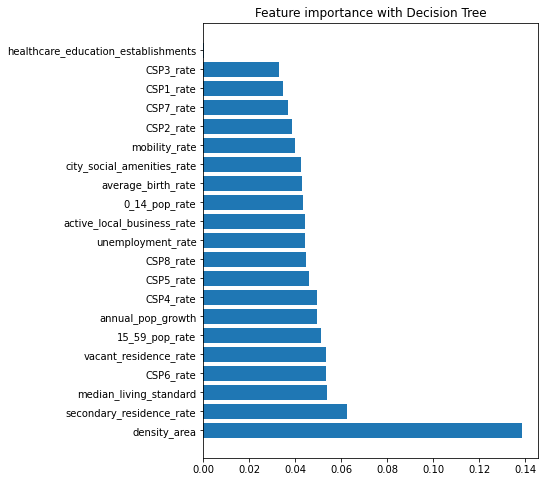

In [290]:
# Plot the results 

plt.figure(figsize=(6,8))
plt.barh([i for i in range(len(feat_scores))], feat_scores, tick_label=feat_names)
plt.title('Feature importance with Decision Tree')
plt.savefig('../img/decisionTree_feature_selection.png')
plt.show()

__________________________________
## Compare models

Run other models to compare the performance and the best fit

- [x] Run pyCaret comparison models
- [x] Compare Accuracy of previous Logistic Regression models with pyCaret output
- [ ] Rebuild manually the best model to check the accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, f1_score

In [ ]:
def compare_classification_models(X,y):

accuracies_train=[]
accuracies_test=[]
precision=[]
f1=[]

scores = pd.DataFrame(columns=['Accu_train','Accu_test','Precision','F1'], index=[str(model) for model in model_list])

skf = StratifiedKFold(n_splits=10, random_state=8, shuffle=True) 

logistic = LogisticRegression(multi_class='multinomial',random_state=8)
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
nayes = GaussianNB()
xbg = xgb()
ada = AdaBoostClassifier()
catboost = CatBoostClassifier()

model_list = [logistic, tree, rf, knn, nayes, xbg, ada, catboost]

for model in model_list:
    print(f'Model executed: {model}')
    
    for train_idx, test_idx in skf.split(X_res,y_res):
        model = model.fit(X.iloc[train_idx,:],y[train_idx])
        
        accuracies_train.append(accuracy_score(y[train_idx],dtree_cv.predict(X.iloc[train_idx,:])))
        accuracies_test.append(accuracy_score(y[test_idx],dtree_cv.predict(X.iloc[test_idx,:])))
        precision.append(precision_score(y[test_idx],dtree_cv.predict(X.iloc[test_idx,:]), average='macro'))
        f1.append(f1_score(y[test_idx],dtree_cv.predict(X.iloc[test_idx,:]), average='macro'))
        
    accuracies_train_model.append()
    accuracies_test_model.append()
    precision_model.append()
    f1_model.append(np.mean(f1))
    
    scores.loc[str(model)] = [np.mean(accuracies_train), np.mean(accuracies_test), 
                              np.mean(precision), np.mean(f1)]
    #print("Average accuracy for train samples:",np.mean(accuracies_train))
    #print("Average accuracy for test samples:",np.mean(accuracies_test))

In [254]:
# Comparison using pycaret library 

#Importing module
from pycaret.classification import *

In [263]:
# Recreating the dataframe with resampled data
df_res = pd.merge(X_res,y_res, 'inner', left_on=X_res.index, right_on=y_res.index).drop('key_0',axis=1)
df_res.head()

,median_living_standard,healthcare_education_establishments,density_area,annual_pop_growth,unemployment_rate,secondary_residence_rate,vacant_residence_rate,active_local_business_rate,city_social_amenities_rate,0_14_pop_rate,15_59_pop_rate,mobility_rate,average_birth_rate,CSP1_rate,CSP2_rate,CSP3_rate,CSP4_rate,CSP5_rate,CSP6_rate,CSP7_rate,CSP8_rate,medical_desert
0,0.223393,0,0.002369,-0.001778,0.086474,0.022467,0.057416,0.606061,0.106061,0.202190,0.555776,8.964232e-03,0.011270,0.006250,0.037500,0.043750,0.156250,0.225000,0.150000,0.250000,0.131250,0
1,0.198459,0,0.000226,-0.040677,0.043478,0.179825,0.059942,0.600000,0.200000,0.085366,0.487805,0.000000e+00,0.000000,0.000000,0.000000,0.214286,0.142857,0.071429,0.071429,0.428571,0.071429,0
2,0.223507,0,0.003465,0.006447,0.055202,0.012158,0.042196,0.544974,0.132275,0.234935,0.594835,1.027492e-02,0.012401,0.003559,0.039146,0.108541,0.197509,0.170819,0.170819,0.190391,0.119217,0
3,0.198450,0,0.000152,-0.015274,0.138889,0.267361,0.170139,0.300000,0.100000,0.085714,0.414286,1.326346e-15,0.007692,0.000000,0.076923,0.000000,0.076923,0.000000,0.384615,0.461538,0.000000,0
4,0.219884,0,0.001519,0.001941,0.056180,0.007450,0.067052,0.377358,0.056604,0.187291,0.551839,1.337793e-02,0.007754,0.140000,0.140000,0.040000,0.120000,0.100000,0.120000,0.220000,0.120000,0


In [278]:
# Initializing setup
clf1 = setup(data = df_res, target = 'medical_desert', numeric_features = ['healthcare_education_establishments'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,7404
1,Target Type,Multiclass
2,Label Encoded,None
3,Original Data,"(16557, 22)"
4,Missing Values,False
5,Numeric Features,21
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [279]:
# comparing all models
compare_models()

IntProgress(value=0, description='Processing: ', max=170)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:22:42
Status,. . . . . . . . . . . . . . . . . .,Fitting Fold 1 of 10
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.5184,0.0,0.5184,0.5146,0.5148,0.2776
1,Gradient Boosting Classifier,0.5160,0.0,0.5160,0.5121,0.5122,0.2740
2,Light Gradient Boosting Machine,0.5155,0.0,0.5155,0.5120,0.5122,0.2732
3,Ada Boost Classifier,0.5070,0.0,0.5070,0.5032,0.5040,0.2606
4,Extra Trees Classifier,0.5065,0.0,0.5065,0.5025,0.5018,0.2598
5,Random Forest Classifier,0.4849,0.0,0.4849,0.4832,0.4795,0.2273
6,Linear Discriminant Analysis,0.4829,0.0,0.4829,0.4775,0.4768,0.2243
7,Ridge Classifier,0.4818,0.0,0.4818,0.4744,0.4714,0.2228
8,Logistic Regression,0.4812,0.0,0.4812,0.4752,0.4740,0.2219
9,SVM - Linear Kernel,0.4673,0.0,0.4673,0.4606,0.4250,0.2009


KeyboardInterrupt: 

In [284]:
# Recreating the dataframe with resampled data
df_res_feat4 = pd.merge(X_res[['secondary_residence_rate','active_local_business_rate', 'CSP1_rate', '0_14_pop_rate']],y_res, 'inner', left_on=X_res.index, right_on=y_res.index).drop('key_0',axis=1)
print(df_res_feat4.shape)
df_res_feat4.head()


(16557, 5)


,secondary_residence_rate,active_local_business_rate,CSP1_rate,0_14_pop_rate,medical_desert
0,0.022467,0.606061,0.006250,0.202190,0
1,0.179825,0.600000,0.000000,0.085366,0
2,0.012158,0.544974,0.003559,0.234935,0
3,0.267361,0.300000,0.000000,0.085714,0
4,0.007450,0.377358,0.140000,0.187291,0


In [286]:
# Initializing setup
clf2 = setup(data = df_res_feat4, target = 'medical_desert')


 
Setup Succesfully Completed!


,Description,Value
0,session_id,2510
1,Target Type,Multiclass
2,Label Encoded,None
3,Original Data,"(16557, 5)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [287]:
# comparing all models with reduced features
compare_models()

IntProgress(value=0, description='Processing: ', max=170)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:22:42
Status,. . . . . . . . . . . . . . . . . .,Fitting Fold 1 of 10
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.4767,0.0,0.4767,0.4756,0.4757,0.2151
1,Gradient Boosting Classifier,0.4750,0.0,0.4750,0.4736,0.4738,0.2125
2,Light Gradient Boosting Machine,0.4700,0.0,0.4700,0.4675,0.4681,0.2050
3,Ada Boost Classifier,0.4690,0.0,0.4690,0.4676,0.4677,0.2035
4,Ridge Classifier,0.4649,0.0,0.4649,0.4592,0.4539,0.1974
5,Linear Discriminant Analysis,0.4637,0.0,0.4637,0.4600,0.4570,0.1956
6,Logistic Regression,0.4635,0.0,0.4635,0.4579,0.4545,0.1953
7,Quadratic Discriminant Analysis,0.4609,0.0,0.4609,0.4662,0.4540,0.1913
8,SVM - Linear Kernel,0.4541,0.0,0.4541,0.4277,0.3861,0.1811
9,Naive Bayes,0.4483,0.0,0.4483,0.4522,0.4364,0.1724


KeyboardInterrupt: 

### Conclusion on model conparison

- We can see models still have a low performance (note above 50% of right prediction) even if we reduce the number of features
- Still Gradient Boosting algorithm appears to be the most performant model
- We may assume the features can't predict the medical desert

**Possible improvements:**
- Build again Gradient Boosting Classifier and perform hypertunning parameters to improve the performance of the model
- Check the feature importance done by Gradient Boosting Classifier
- Do PCA on the 4 or 7 best features
- Create bin of continuous variable and run again the models because classification can be quite sensitive to continuous variables
- Change the threshold used to create the labels